In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import networkx as nx

from coppeliasim_zmqremoteapi_client import RemoteAPIClient 

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

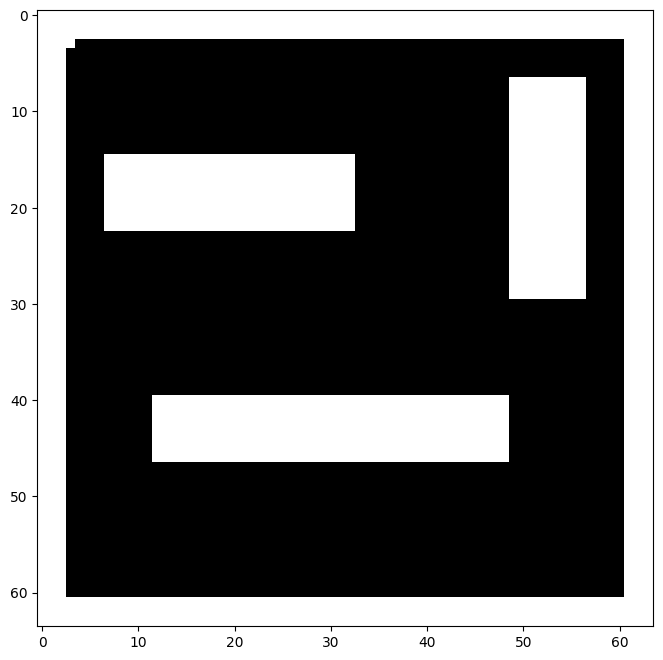

In [6]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('mapas_meus/teste1_invertido.png')
#img = 1 - mpimg.imread('img/maze.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

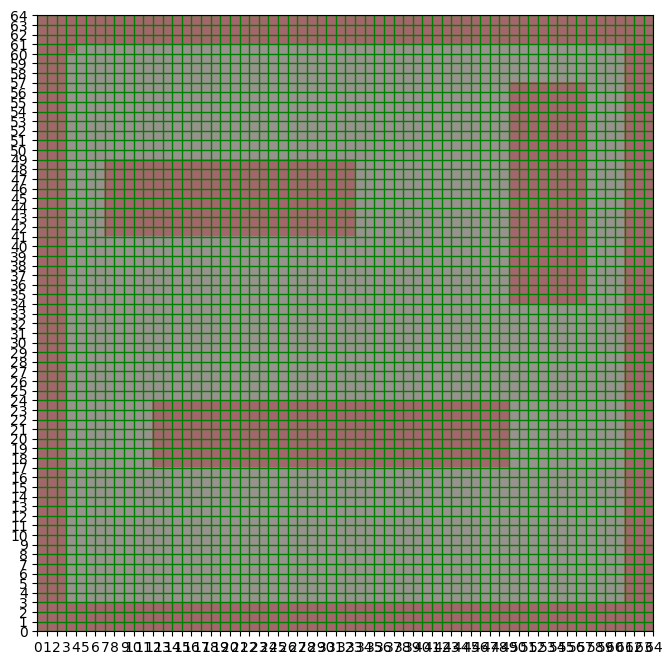

In [14]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([64, 64]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape[:2] / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 1

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='green', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

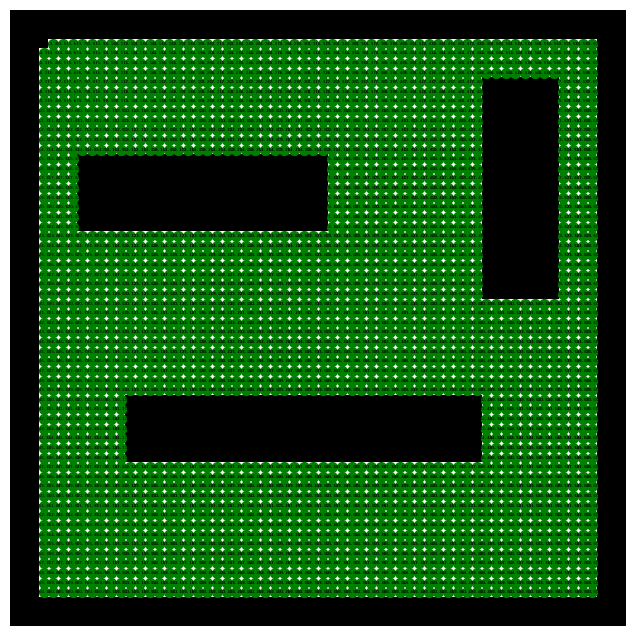

In [21]:
# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

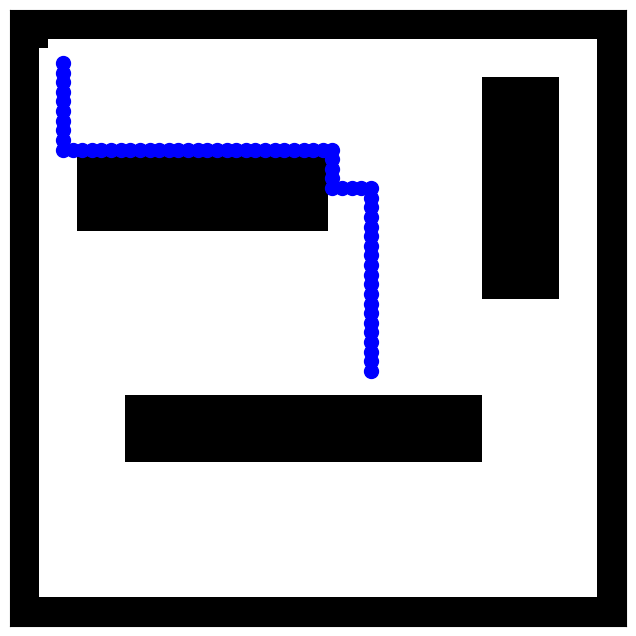

In [35]:
# Finalmente podemos determinar o menor caminho entre duas células
# ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo

# Cave
start_node =  (5, 5)
end_node = (37, 37)


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

In [38]:
print(path)
print(G)
print(pos)

[(5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (14, 21), (14, 22), (14, 23), (14, 24), (14, 25), (14, 26), (14, 27), (14, 28), (14, 29), (14, 30), (14, 31), (14, 32), (14, 33), (15, 33), (16, 33), (17, 33), (18, 33), (18, 34), (18, 35), (18, 36), (18, 37), (19, 37), (20, 37), (21, 37), (22, 37), (23, 37), (24, 37), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37)]
Graph with 2712 nodes and 5199 edges
{(3, 4): (4.5, np.float64(60.5)), (3, 5): (5.5, np.float64(60.5)), (3, 6): (6.5, np.float64(60.5)), (3, 7): (7.5, np.float64(60.5)), (3, 8): (8.5, np.float64(60.5)), (3, 9): (9.5, np.float64(60.5)), (3, 10): (10.5, np.float64(60.5)), (3, 11): (11.5, np.float64(60.5)), (3, 12): (12.5, np.float64(60.5)), (3, 13): (13.5, np.float64(

In [18]:
# Connect to the CoppeliaSim server
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

# Handle para o ROBÔ
robotname = 'robotino'
robotHandle = sim.getObject('/' + robotname)


# Coordenadas desejadas no mundo [x, y, z]
start_pos = [-3, -4, 0.04]  # em metros

# Orientação inicial (em radianos)
# [roll, pitch, yaw]
start_ori = [0, 0, np.deg2rad(90)]

# Aplicar no simulador
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
# sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)



# Handle para as juntas das RODAS
wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')

# Dados Robotino
L = 0.135   # Metros
r = 0.040   # Metros
           
# Cinemática Direta
Mdir = np.array([[-r/np.sqrt(3),     0,        r/np.sqrt(3)], 
                 [r/3,            (-2*r)/3,    r/3], 
                 [r/(3*L),         r/(3*L),    r/(3*L)]])


# Configuração inicial (x, y, w)
q = np.array([0, 0, 0.5])

# Lembrar de habilitar o 'Real-time mode'    
# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

# Inicia a simulação
sim.startSimulation()
sim.step()

print("Starting robot control loop...")
while (sim_time := sim.getSimulationTime()) <= 15:
    print(f"Simulation time: {sim_time:.2f} [s]")
    
    dt = sim.getSimulationTimeStep()
    
    # Cinemática Direta
    u = [np.deg2rad(45), np.deg2rad(45), np.deg2rad(45)]
    
    # Velocidade desejada (x, y, w)    
    if sim_time <= 5:
        qdot = np.array([.2, 0, np.deg2rad(10)])
    elif sim_time <= 10:    
        qdot = np.array([0, -.2, np.deg2rad(-10)])
    else:
        qdot = np.array([-.2, 0, 0])
    
    #qdot = np.array([0, .3, 0])
    
    # Cinemática Inversa
    # w1, w2, w3
    Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
    u = Minv @ qdot
    # Enviando velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2]) 
    
    # Calculando posição
    q = q + (Rz(q[2]) @ Mdir @ u)*dt
    sim.step()
    
# Parando o robô
print("Stopping robot...")
sim.setJointTargetVelocity(wheel1, 0)
sim.setJointTargetVelocity(wheel2, 0)
sim.setJointTargetVelocity(wheel3, 0)

print('CALC Pos: ', sim_time, q[:2], np.rad2deg(q[2]))
  
pos = sim.getObjectPosition(robotHandle, sim.handle_world)
print('SIM Pos: ', pos)
ori = sim.getObjectOrientation(robotHandle, sim.handle_world)
print('SIM Ori: ', np.rad2deg(ori))
    
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')

Starting robot control loop...
Simulation time: 0.05 [s]
Simulation time: 0.10 [s]
Simulation time: 0.15 [s]
Simulation time: 0.20 [s]
Simulation time: 0.25 [s]
Simulation time: 0.30 [s]
Simulation time: 0.35 [s]
Simulation time: 0.40 [s]
Simulation time: 0.45 [s]
Simulation time: 0.50 [s]
Simulation time: 0.55 [s]
Simulation time: 0.60 [s]
Simulation time: 0.65 [s]
Simulation time: 0.70 [s]
Simulation time: 0.75 [s]
Simulation time: 0.80 [s]
Simulation time: 0.85 [s]
Simulation time: 0.90 [s]
Simulation time: 0.95 [s]
Simulation time: 1.00 [s]
Simulation time: 1.05 [s]
Simulation time: 1.10 [s]
Simulation time: 1.15 [s]
Simulation time: 1.20 [s]
Simulation time: 1.25 [s]
Simulation time: 1.30 [s]
Simulation time: 1.35 [s]
Simulation time: 1.40 [s]
Simulation time: 1.45 [s]
Simulation time: 1.50 [s]
Simulation time: 1.55 [s]
Simulation time: 1.60 [s]
Simulation time: 1.65 [s]
Simulation time: 1.70 [s]
Simulation time: 1.75 [s]
Simulation time: 1.80 [s]
Simulation time: 1.85 [s]
Simulat

Starting robot control loop...
Simulation time: 0.05 [s]
Simulation time: 0.10 [s]
Simulation time: 0.15 [s]
Simulation time: 0.20 [s]
Simulation time: 0.25 [s]
Simulation time: 0.30 [s]
Simulation time: 0.35 [s]
Simulation time: 0.40 [s]
Simulation time: 0.45 [s]
Simulation time: 0.50 [s]
Simulation time: 0.55 [s]
Simulation time: 0.60 [s]
Simulation time: 0.65 [s]
Simulation time: 0.70 [s]
Simulation time: 0.75 [s]
Simulation time: 0.80 [s]
Simulation time: 0.85 [s]
Simulation time: 0.90 [s]
Simulation time: 0.95 [s]
Simulation time: 1.00 [s]
Simulation time: 1.05 [s]
Simulation time: 1.10 [s]
Simulation time: 1.15 [s]
Simulation time: 1.20 [s]
Simulation time: 1.25 [s]
Simulation time: 1.30 [s]
Simulation time: 1.35 [s]
Simulation time: 1.40 [s]
Simulation time: 1.45 [s]
Simulation time: 1.50 [s]
Simulation time: 1.55 [s]
Simulation time: 1.60 [s]
Simulation time: 1.65 [s]
Simulation time: 1.70 [s]
Simulation time: 1.75 [s]
Simulation time: 1.80 [s]
Simulation time: 1.85 [s]
Simulat

In [10]:
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Handle para o ROBÔ
    robotname = 'robotino'
    robotHandle = sim.getObject('/' + robotname)
    
    # Handle para as juntas das RODAS
    wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
    wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
    wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')
              
    # Dados Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros  
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
           
    # Goal configuration (x, y, theta)    
    qgoal = np.array([3, 3, np.deg2rad(90)])
    #qgoal = np.array([3, -3, np.deg2rad(-90)])
    #qgoal = np.array([0, 0, np.deg2rad(0)])
    
    # Lembrar de habilitar o 'Real-time mode'    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()

    # Frame que representa o Goal
    goalFrame = sim.getObject('/Goal')
    sim.setObjectPosition(goalFrame, [qgoal[0], qgoal[1], 0], sim.handle_world)
    sim.setObjectOrientation(goalFrame, [0, 0, qgoal[2]], sim.handle_world)
    
    gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    #gain = np.array([[0.3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    
    print("Starting robot control loop...")
    while (sim_time := sim.getSimulationTime()) <= 90:
        print(f"Simulation time: {sim_time:.2f} [s]")
        
        dt = sim.getSimulationTimeStep()
                
        pos = sim.getObjectPosition(robotHandle, sim.handle_world)
        ori = sim.getObjectOrientation(robotHandle, sim.handle_world)

        q = np.array([pos[0], pos[1], ori[2]])
        
        error = qgoal - q
        print(f"Error: {np.linalg.norm(error[:2])}")
        
        # Margem aceitável de distância
        if (np.linalg.norm(error[:2]) < 0.05):
            break

        # Controller
        qdot = gain @ error
        
        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
        u = Minv @ qdot
        
        # Enviando velocidades
        sim.setJointTargetVelocity(wheel1, u[0])
        sim.setJointTargetVelocity(wheel2, u[1])
        sim.setJointTargetVelocity(wheel3, u[2]) 
                
        sim.step()

    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)
    
except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')

An error occurred: 1254: in sim._getObject: object does not exist, or alias/path is ill formatted.
Program ended
